### Focusing on edges of filaments, looking at fronts
#### - look for divergence/convergence along fronts
#### - differences in magnitude between transects


In [1]:
#from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy as sp
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import urllib.request
import xarray as xr
import pandas as pd
import glob
import os
#from datetime import datetime
import datetime as dt
from collections import OrderedDict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from oceans.datasets import etopo_subset
from oceans.sw_extras import gamma_GP_from_SP_pt
from matplotlib.patches import Polygon
import gsw
from matplotlib import animation, rc
from IPython.display import HTML
import scipy.io
#import pixiedust # for pixie_debugger
import pycwt as wavelet
from pyspec import helmholtz as helm
from pyspec import spectrum as spec    
from itertools import islice # for slice OrderedDict

os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files") # need to set working directory to get the next step to work
from Benguela.src.met132_ctd_ladcp_functions import load_combine_ladcp_ctd_data #import load_ctd_data
from Benguela.src.met132_scanfish_sadcp_functions import load_combine_sadcp_scanfish_data #import load_ctd_data
import Benguela.src.met132_calc_functions as cf
import Benguela.src.met132_plotting_functions as fg
import Benguela.src.met132_sea_level_functions as sl
import Denmark_Strait.src.spectra_and_wavelet_functions as sw
import Denmark_Strait.src.ssa_core as ssa

# some colors (prettier than default boring colors)
color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

============================================================================================================================

#### Load the data

In [4]:
# ====== load SADCP and Scanfish data
# from netcdf
#sadcp_filenames = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/sadcp_transects_500m.nc'
#sadcp_transects_500m = xr.open_dataset(sadcp_filenames) 
sadcp_nc_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/'
#sadcp_transects_1km = xr.open_dataset(sadcp_filenames) 

scan_sadcp_transects_1km = OrderedDict() # Preallocate output dictionary
scan_sadcp_transects_1km['ScanTransect1'] = xr.open_dataset((sadcp_nc_dir+'scan_sadcp_transects_1km_ScanTransect1.nc')) 
scan_sadcp_transects_1km['ScanTransect1'] = scan_sadcp_transects_1km['ScanTransect1'].set_index(xy=['x_m','x_km','lat','lon','time','time_secs'])
scan_sadcp_transects_1km['ScanTransect2'] = xr.open_dataset((sadcp_nc_dir+'scan_sadcp_transects_1km_ScanTransect2.nc')) 
scan_sadcp_transects_1km['ScanTransect2'] = scan_sadcp_transects_1km['ScanTransect2'].set_index(xy=['x_m','x_km','lat','lon','time','time_secs'])
# actually just sadcp data, but putting them in same Dict
scan_sadcp_transects_1km['LADCP_CTD_Transect1'] = xr.open_dataset((sadcp_nc_dir+'sadcp_transects_1km_LADCP_CTD_Transect1.nc')) 
scan_sadcp_transects_1km['LADCP_CTD_Transect1'] = scan_sadcp_transects_1km['LADCP_CTD_Transect1'].set_index(xy=['x_m','x_km','lat','lon','time','time_secs'])
scan_sadcp_transects_1km['LADCP_CTD_Transect5'] = xr.open_dataset((sadcp_nc_dir+'sadcp_transects_1km_LADCP_CTD_Transect5.nc')) 
scan_sadcp_transects_1km['LADCP_CTD_Transect5'] = scan_sadcp_transects_1km['LADCP_CTD_Transect5'].set_index(xy=['x_m','x_km','lat','lon','time','time_secs'])

ctd_ladcp_transects_1km = OrderedDict() # Preallocate output dictionary
ctd_ladcp_transects_1km['LADCP_CTD_Transect1'] = xr.open_dataset((sadcp_nc_dir+'ctd_ladcp_transects_LADCP_CTD_Transect1.nc')) 
ctd_ladcp_transects_1km['LADCP_CTD_Transect1'] = ctd_ladcp_transects_1km['LADCP_CTD_Transect1'].set_index(xy=['x_m','x_km','lat','lon','time','station'])
ctd_ladcp_transects_1km['LADCP_CTD_Transect5'] = xr.open_dataset((sadcp_nc_dir+'ctd_ladcp_transects_LADCP_CTD_Transect5.nc')) 
ctd_ladcp_transects_1km['LADCP_CTD_Transect5'] = ctd_ladcp_transects_1km['LADCP_CTD_Transect5'].set_index(xy=['x_m','x_km','lat','lon','time','station'])

filenames = "/Volumes/Backup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016323.L3m_DAY_SST_sst_4km.nc"
sst_map_18 = xr.open_dataset(filenames) # lat,lon,sst
filenames = "/Volumes/Backup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016324.L3m_DAY_SST_sst_4km.nc"
sst_map_19 = xr.open_dataset(filenames) # lat,lon,sst
filenames = "/Volumes/Backup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016333.L3m_DAY_SST_sst_4km.nc"
sst_map_28 = xr.open_dataset(filenames) # lat,lon,sst


============================================================================================================================

#### Scanfish/SADCP Transects: Looking at divergence/convergence near fronts

In [8]:
def get_turb_velocities(scan_sadcp_transects,var_name):
    scan_sadcp_transects[var_name+'_prime']=scan_sadcp_transects[var_name]-scan_sadcp_transects[var_name].mean(dim='xy')
    
    return scan_sadcp_transects

scan_sadcp_transects_1km['ScanTransect1'] = get_turb_velocities(scan_sadcp_transects_1km['ScanTransect1'],'along')
scan_sadcp_transects_1km['ScanTransect1'] = get_turb_velocities(scan_sadcp_transects_1km['ScanTransect1'],'across')
scan_sadcp_transects_1km['ScanTransect1'] = get_turb_velocities(scan_sadcp_transects_1km['ScanTransect1'],'u')
scan_sadcp_transects_1km['ScanTransect1'] = get_turb_velocities(scan_sadcp_transects_1km['ScanTransect1'],'v')
scan_sadcp_transects_1km['ScanTransect1']['zero_vel']=scan_sadcp_transects_1km['ScanTransect1']['u']*0

scan_sadcp_transects_1km['ScanTransect2'] = get_turb_velocities(scan_sadcp_transects_1km['ScanTransect2'],'along')
scan_sadcp_transects_1km['ScanTransect2'] = get_turb_velocities(scan_sadcp_transects_1km['ScanTransect2'],'across')
scan_sadcp_transects_1km['ScanTransect2'] = get_turb_velocities(scan_sadcp_transects_1km['ScanTransect2'],'u')
scan_sadcp_transects_1km['ScanTransect2'] = get_turb_velocities(scan_sadcp_transects_1km['ScanTransect2'],'v')
scan_sadcp_transects_1km['ScanTransect2']['zero_vel']=scan_sadcp_transects_1km['ScanTransect2']['u']*0


/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a

In [7]:
from mpl_toolkits.basemap import Basemap
def quick_map(scan_sadcp,var1,var2,sst_map,lon_0,lat_0,bwidth, bheight,z_ind,ax_in,reverse_flag=None,sst_range=np.arange(15.,17.51,0.25) ):
    m = Basemap(width=bwidth,height=bheight,resolution='i',projection='aea',lon_0=lon_0,lat_0=lat_0)
    m.ax = ax_in
    #m.drawcoastlines(), m.fillcontinents(color='0.85')
    m.drawparallels(np.arange(-90.,91.,1.),labels=[True,False,False,False],dashes=[2,2]), m.drawmeridians(np.arange(-180.,181.,1.),labels=[False,False,False,True],dashes=[2,2])

    # === SST MAP ===
    #sst_range = np.arange(15.,17.51,0.25)       
    lon2, lat2 = np.meshgrid(sst_map.lon.values,sst_map.lat.values)
    #m.contourf(lon2, lat2, sst_map.analysed_sst[0,:,:],40,cmap=plt.cm.coolwarm,latlon=True)
    #sst_plt = m.pcolormesh(lon2, lat2, sst_map.sst,vmin=sst_range[0],vmax=sst_range[1],cmap=plt.cm.coolwarm,latlon=True)
    sst_plt = m.contour(lon2, lat2, sst_map.sst,levels = sst_range, cmap=plt.cm.viridis,latlon=True)
    plt.text(1,1,sst_map.time_coverage_start[:-8],transform=m.ax.transAxes,horizontalalignment='right',verticalalignment='bottom')        
    plt.text(1,1,(var1 + ' & ' + var2),transform=m.ax.transAxes,horizontalalignment='right',verticalalignment='top')        

    m.plot(scan_sadcp.lon.values,scan_sadcp.lat.values, lw = 2, latlon=True)
    skip=2
    if reverse_flag:
        sadcp_plt = m.quiver(scan_sadcp.lon.dropna('xy')[::skip].values, scan_sadcp.lat.dropna('xy')[::skip].values, 
                                  -1*scan_sadcp[var1].sel(z=z_ind,method='nearest').dropna('xy')[::skip].values,
                                  -1*scan_sadcp[var2].sel(z=z_ind,method='nearest').dropna('xy')[::skip].values,
                                  latlon=True)
    else:
        sadcp_plt = m.quiver(scan_sadcp.lon.dropna('xy')[::skip].values, scan_sadcp.lat.dropna('xy')[::skip].values, 
                                  scan_sadcp[var1].sel(z=z_ind,method='nearest').dropna('xy')[::skip].values,
                                  scan_sadcp[var2].sel(z=z_ind,method='nearest').dropna('xy')[::skip].values,
                                  latlon=True)
    start_end_date = pd.Series([scan_sadcp.time[0].values,scan_sadcp.time[-1].values])
    plt.text(0,0,(str(start_end_date[0].year)+'-'+str(start_end_date[0].month)+'-'+str(start_end_date[0].day)+':'+str(start_end_date[1].month)+'-'+str(start_end_date[1].day)),
                  transform=m.ax.transAxes,horizontalalignment='left',verticalalignment='bottom')        

    #m.drawmapscale(14.5, -25.5, 15, -25.5, 50,barstyle='fancy')
    return m
    
def plt_vel_and_CT(track_name,var_name,si,reverse_flag=None,ctd_ladcp_transects_1km=None):
    if reverse_flag:
        (-1*scan_sadcp_transects_1km[track_name][var_name]-(-1*scan_sadcp_transects_1km[track_name][var_name].mean(dim='xy'))).reset_index('xy').plot(
            x='x_m',ax=ax[si],add_colorbar=True,ylim=(-100,0),vmax=vel_range[1],
            cbar_kwargs={'orientation':"horizontal",'pad': -0.2,'label':'','shrink':0.2,'aspect':10})
    else:
        (scan_sadcp_transects_1km[track_name][var_name]-scan_sadcp_transects_1km[track_name][var_name].mean(dim='xy')).reset_index('xy').plot(
            x='x_m',ax=ax[si],add_colorbar=True,ylim=(-100,0),vmax=vel_range[1],
            cbar_kwargs={'orientation':"horizontal",'pad': -0.2,'label':'','shrink':0.2,'aspect':10})
    if ctd_ladcp_transects_1km:
        ctd_ladcp_transects_1km[track_name].CT.reset_index('xy').plot.contour(x='x_m',y='z',levels = CT_levels,cmap=plt.cm.viridis,linewidths=2,ax=ax[si])
    else:
        scan_sadcp_transects_1km[track_name].CT.reset_index('xy').plot.contour(x='x_m',y='z',levels = CT_levels,cmap=plt.cm.viridis,linewidths=2,ax=ax[si])
    ax[si].text(0,1,(var_name + '-velocity: -ve southwards'),transform=ax[si].transAxes,horizontalalignment='left',verticalalignment='top')


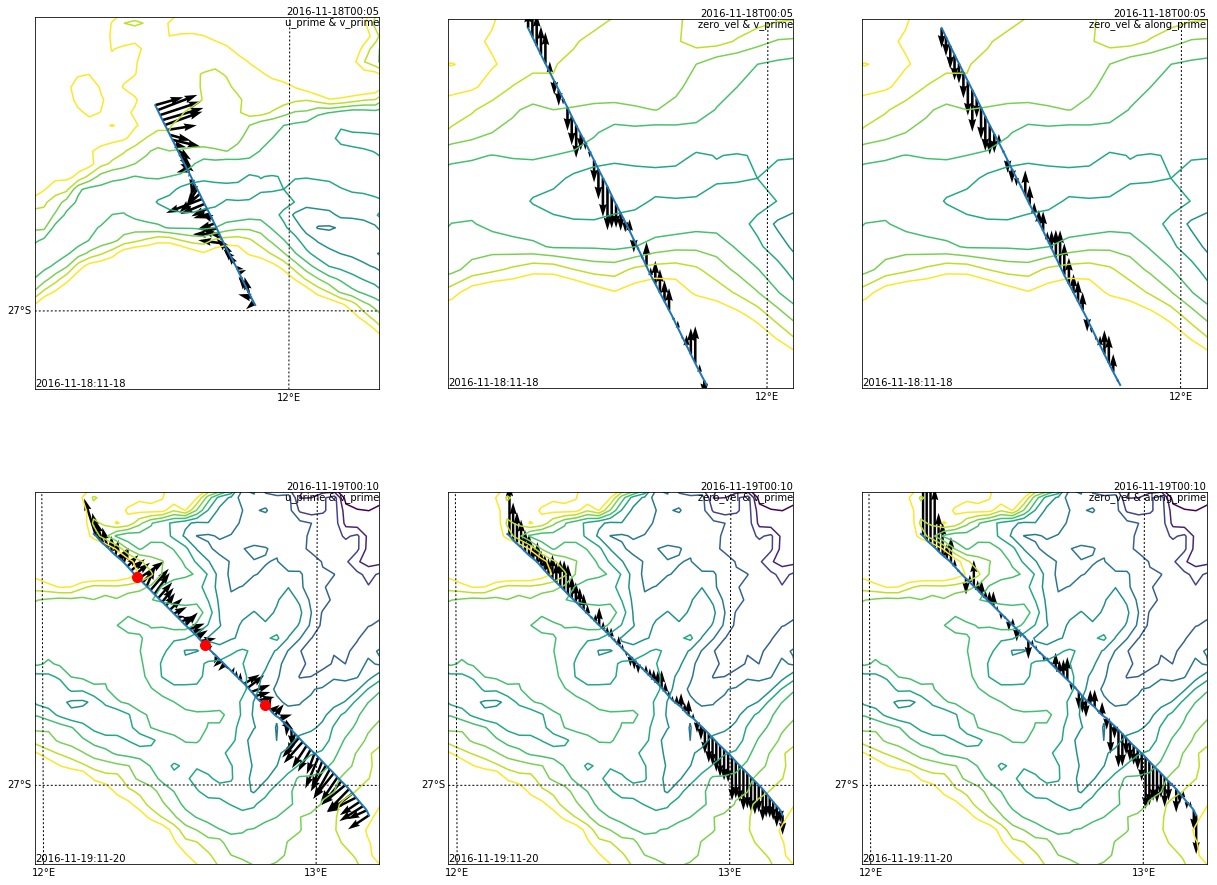

In [16]:


fig, ax = plt.subplots(ncols = 3,nrows=2, figsize=(21,16))
bwidth, bheight = 125000,135000 
quick_map(scan_sadcp_transects_1km['ScanTransect1'],'u_prime','v_prime',sst_map_18,11.7,-26.65, bwidth, bheight,z_ind=-25,ax_in=ax[0,0])
bwidth, bheight = 70000,75000
quick_map(scan_sadcp_transects_1km['ScanTransect1'],'zero_vel','v_prime',sst_map_18,11.7,-26.65, bwidth, bheight,z_ind=-25,ax_in=ax[0,1])
quick_map(scan_sadcp_transects_1km['ScanTransect1'],'zero_vel','along_prime',sst_map_18,11.7,-26.65, bwidth, bheight,z_ind=-25,ax_in=ax[0,2],reverse_flag=True)

bwidth, bheight = 125000,135000
m_last = quick_map(scan_sadcp_transects_1km['ScanTransect2'],'u_prime','v_prime',sst_map_19,12.6,-26.65, bwidth, bheight, z_ind=-25,ax_in=ax[1,0])
m_last.plot(scan_sadcp_transects_1km['ScanTransect2'].lon.sel(x_m=(120990)).values,scan_sadcp_transects_1km['ScanTransect2'].lat.sel(x_m=(120990)).values,
            marker='o',color='red',markersize=10,latlon=True)
m_last.plot(scan_sadcp_transects_1km['ScanTransect2'].lon.sel(x_m=(85991)).values,scan_sadcp_transects_1km['ScanTransect2'].lat.sel(x_m=(85991)).values,
            marker='o',color='red',markersize=10,latlon=True)
m_last.plot(scan_sadcp_transects_1km['ScanTransect2'].lon.sel(x_m=(54992)).values,scan_sadcp_transects_1km['ScanTransect2'].lat.sel(x_m=(54992)).values,
            marker='o',color='red',markersize=10,latlon=True)
quick_map(scan_sadcp_transects_1km['ScanTransect2'],'zero_vel','v_prime',sst_map_19,12.6,-26.65, bwidth, bheight,z_ind=-25,ax_in=ax[1,1])
quick_map(scan_sadcp_transects_1km['ScanTransect2'],'zero_vel','along_prime',sst_map_19,12.6,-26.65, bwidth, bheight,z_ind=-25,ax_in=ax[1,2])


#### Figure caption: Map of transect of interest with vectors showing both components of eddy velocity (left panel), v-component of eddy velocity (middle) and along-track component (right panel). The upper panels show the first Scanfish transect, the bottom panels the second transect. The coloured line contours show SST, with a colormap that matches the following plots. The eddy velocity simply means the velocity after removing the mean. Image dates are shown in the top right, transect dates in the bottom left.

/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a

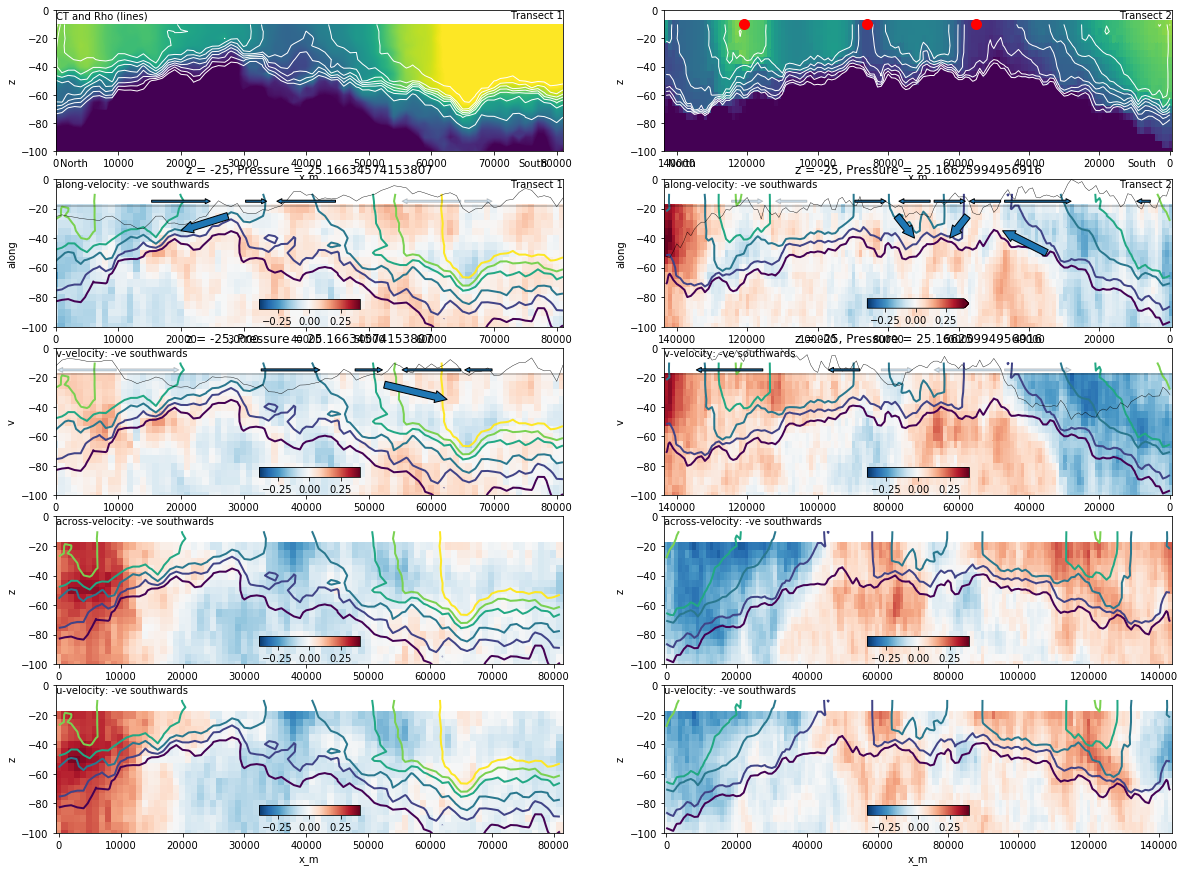

In [53]:
# VELOCITIES (minus mean) ACROSS THE FRONT

sigma_range = np.array((25,26.)) #Rho_range-1000
sigma_levels = np.arange(sigma_range[0]+.1,sigma_range[1]+.1,0.05)
CT_range = np.array((15.,17.51)) #Rho_range-1000
CT_levels = np.arange(CT_range[0],CT_range[1],0.5)
CT_levels2 = np.arange(CT_range[0],CT_range[1],0.01)
vel_range = np.array((-0.4,0.4))

ncols, nrows = 2, 5
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,15))
ax = ax.ravel()

si = 0
scan_sadcp_transects_1km['ScanTransect1'].CT.reset_index('xy').plot.contourf(x='x_m',y='z',ax=ax[si],add_colorbar=False,cmap=plt.cm.viridis,levels=CT_levels2,ylim=(-100,0))
scan_sadcp_transects_1km['ScanTransect1'].sigma_0.reset_index('xy').plot.contour(x='x_m',y='z',levels = sigma_levels,colors='white',linewidths=1,ax=ax[si])
ax[si].text(0,1,'CT and Rho (lines)',transform=ax[si].transAxes,horizontalalignment='left',verticalalignment='top')
ax[si].text(1,1,'Transect 1',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='top')
ax[si].text(5/80,-0.12,'North',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='bottom')
ax[si].text(7.75/8,-0.12,'South',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='bottom')
x_lim1 = ax[si].get_xlim()
si = 1
scan_sadcp_transects_1km['ScanTransect2'].CT.reset_index('xy').plot.pcolormesh(x='x_m',y='z',ax=ax[si],add_colorbar=False,cmap=plt.cm.viridis,levels=CT_levels2,ylim=(-100,0))
scan_sadcp_transects_1km['ScanTransect2'].sigma_0.reset_index('xy').plot.contour(x='x_m',y='z',levels = sigma_levels,colors='white',linewidths=1,ax=ax[si])
ax[si].text(1,1,'Transect 2',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='top')
ax[si].plot(scan_sadcp_transects_1km['ScanTransect2'].x_m.sel(x_m=120990).values,-10,marker='o',color='red',markersize=10)
ax[si].plot(scan_sadcp_transects_1km['ScanTransect2'].x_m.sel(x_m=85991).values,-10,marker='o',color='red',markersize=10)
ax[si].plot(scan_sadcp_transects_1km['ScanTransect2'].x_m.sel(x_m=54992).values,-10,marker='o',color='red',markersize=10)
# flipping x axis to match Transect 1 - North to South
x_lim2 = ax[si].get_xlim()
ax[si].set_xlim(x_lim2[1],x_lim2[0])
x_lim2 = ax[si].get_xlim()
ax[si].text(5/80,-0.12,'North',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='bottom')
ax[si].text(7.75/8,-0.12,'South',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='bottom')

si = 2
plt_vel_and_CT(track_name='ScanTransect1',var_name='along',si=si,reverse_flag=True) # reversed to -ve southwards
ax[si].text(1,1,'Transect 1',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='top')
ax[si].annotate("", xy=(2.5e4, -15), xytext=(1.5e4, -15),arrowprops=dict(arrowstyle="simple"))
ax[si].annotate("", xy=(3.4e4, -15), xytext=(3e4, -15),arrowprops=dict(arrowstyle="simple"))
ax[si].annotate("", xy=(3.5e4, -15), xytext=(4.5e4, -15),arrowprops=dict(arrowstyle="simple"))
ax[si].annotate("", xy=(5.5e4, -15), xytext=(6.5e4, -15),arrowprops=dict(arrowstyle="simple",alpha=0.2))
ax[si].annotate("", xy=(7e4, -15), xytext=(6.5e4, -15),arrowprops=dict(arrowstyle="simple",alpha=0.2))
ax[si].annotate("", xy=(2e4, -35), xytext=(2.75e4, -25),arrowprops=dict(width=7,alpha=1))
z_top = 18 # showing velocities at z_ind as line, to check -ve vs +ve
((-100*scan_sadcp_transects_1km['ScanTransect1']['along']-(-100*scan_sadcp_transects_1km['ScanTransect1']['along'].mean(dim='xy')))-z_top).reset_index('xy').sel(z=-25,method='nearest').plot(
    x='x_m',ax=ax[si],xlim=x_lim1,linewidth=0.4,color='black')
ax[si].axhline(y=-z_top,linewidth=0.4,color='black')

plt_vel_and_CT(track_name='ScanTransect1',var_name='v',si=si+2)
ax[si+2].annotate("", xy=(2e4, -15), xytext=(1e4, -15),arrowprops=dict(arrowstyle="simple",alpha=0.2))
ax[si+2].annotate("", xy=(0, -15), xytext=(1e4, -15),arrowprops=dict(arrowstyle="simple",alpha=0.2))
ax[si+2].annotate("", xy=(4.25e4, -15), xytext=(3.25e4, -15),arrowprops=dict(arrowstyle="simple"))
ax[si+2].annotate("", xy=(5.25e4, -15), xytext=(4.75e4, -15),arrowprops=dict(arrowstyle="simple"))
ax[si+2].annotate("", xy=(5.5e4, -15), xytext=(6.5e4, -15),arrowprops=dict(arrowstyle="simple"))
ax[si+2].annotate("", xy=(6.5e4, -15), xytext=(7e4, -15),arrowprops=dict(arrowstyle="simple"))
ax[si+2].annotate("", xy=(6.25e4, -35), xytext=(5.25e4, -25),arrowprops=dict(width=7,alpha=1))
z_top = 18 # showing velocities at z_ind as line, to check -ve vs +ve
((100*scan_sadcp_transects_1km['ScanTransect1']['v']-(100*scan_sadcp_transects_1km['ScanTransect1']['v'].mean(dim='xy')))-z_top).reset_index('xy').sel(z=-25,method='nearest').plot(
    x='x_m',ax=ax[si+2],xlim=x_lim1,linewidth=0.4,color='black')
ax[si+2].axhline(y=-z_top,linewidth=0.4,color='black')

si = 3
plt_vel_and_CT(track_name='ScanTransect2',var_name='along',si=si)
((-100*scan_sadcp_transects_1km['ScanTransect2']['along']-(-100*scan_sadcp_transects_1km['ScanTransect2']['along'].mean(dim='xy')))-z_top).reset_index('xy').sel(z=-25,method='nearest').plot(
    x='x_m',ax=ax[si],xlim=x_lim2,linewidth=0.4,color='black')
ax[si].axhline(y=-z_top,linewidth=0.4,color='black')
ax[si].text(1,1,'Transect 2',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='top')
ax[si].annotate("", xy=(1e4, -15), xytext=(0.5e4, -15),arrowprops=dict(arrowstyle="simple",alpha=1))
ax[si].annotate("", xy=(2.75e4, -15), xytext=(4.75e4, -15),arrowprops=dict(arrowstyle="simple",alpha=1))
ax[si].annotate("", xy=(5.75e4, -15), xytext=(4.75e4, -15),arrowprops=dict(arrowstyle="simple",alpha=1))
ax[si].annotate("", xy=(5.75e4, -15), xytext=(6.75e4, -15),arrowprops=dict(arrowstyle="simple",alpha=1))
ax[si].annotate("", xy=(7.75e4, -15), xytext=(6.75e4, -15),arrowprops=dict(arrowstyle="simple",alpha=1))
ax[si].annotate("", xy=(8e4, -15), xytext=(9e4, -15),arrowprops=dict(arrowstyle="simple",alpha=1))
ax[si].annotate("", xy=(11.25e4, -15), xytext=(10.25e4, -15),arrowprops=dict(arrowstyle="simple",alpha=0.2))
ax[si].annotate("", xy=(11.5e4, -15), xytext=(12.5e4, -15),arrowprops=dict(arrowstyle="simple",alpha=0.2))
ax[si].annotate("", xy=(14.5e4, -15), xytext=(12.5e4, -15),arrowprops=dict(arrowstyle="simple",alpha=0.2))
ax[si].annotate("", xy=(4.75e4, -35), xytext=(3.5e4, -50),arrowprops=dict(alpha=1,width=7))
ax[si].annotate("", xy=(6.25e4, -40), xytext=(5.75e4, -25),arrowprops=dict(alpha=1,width=7))
ax[si].annotate("", xy=(7.25e4, -40), xytext=(7.75e4, -25),arrowprops=dict(alpha=1,width=7))

plt_vel_and_CT(track_name='ScanTransect2',var_name='v',si=si+2)
((100*scan_sadcp_transects_1km['ScanTransect2']['v']-(100*scan_sadcp_transects_1km['ScanTransect2']['v'].mean(dim='xy')))-z_top).reset_index('xy').sel(z=-25,method='nearest').plot(
    x='x_m',ax=ax[si+2],xlim=x_lim2,linewidth=0.4,color='black')
ax[si+2].axhline(y=-z_top,linewidth=0.4,color='black')
ax[si+2].annotate("", xy=(2.75e4, -15), xytext=(4.75e4, -15),arrowprops=dict(arrowstyle="simple",alpha=0.2))
ax[si+2].annotate("", xy=(6.75e4, -15), xytext=(4.75e4, -15),arrowprops=dict(arrowstyle="simple",alpha=0.2))
ax[si+2].annotate("", xy=(7.25e4, -15), xytext=(8.25e4, -15),arrowprops=dict(arrowstyle="simple",alpha=0.2))
ax[si+2].annotate("", xy=(9.75e4, -15), xytext=(8.75e4, -15),arrowprops=dict(arrowstyle="simple",alpha=1))
ax[si+2].annotate("", xy=(13.5e4, -15), xytext=(11.5e4, -15),arrowprops=dict(arrowstyle="simple",alpha=1))

si = 6
plt_vel_and_CT(track_name='ScanTransect1',var_name='across',si=si,reverse_flag=True) # reversed to -ve southwards
plt_vel_and_CT(track_name='ScanTransect1',var_name='u',si=si+2)

si = 7
plt_vel_and_CT(track_name='ScanTransect2',var_name='across',si=si)
plt_vel_and_CT(track_name='ScanTransect2',var_name='u',si=si+2)



#### Figure caption: Cross-sections along the transects shown in the figure above, Scanfish transect 1 (left panels) and 2 (right panels). The top row shows temperature (colour) and density (lines). The remaining plots show temperature as coloured contour lines and (top to bottom): along-ship velocity component, v-component, across-track component, u-component. The thick blue arrows are "hand drawn" and indicate across-filament flow direction, and resulting downwelling or upwelling along the filament edges. Sometimes the across-track and sometimes the v-component was used (see map plots above). The red dots were used to link locations in the map plot, with locations in the cross-sections.

In [6]:
def calc_gws(power,N,scales,std2,dt,alpha,slevel,dof,mother,gws_range,dat):

    # Calculates the global wavelet spectrum and determines its significance level.
    glbl_power = power.mean(axis=1)
    dof = N - scales                     # Correction for padding at edges
    glbl_signif, tmp = wavelet.significance(std2.values, dt, scales, 1, alpha,
                                            significance_level=slevel, dof=dof,
                                            wavelet=mother)
    glbl_signif = N*dt*glbl_signif/scales # rpn !!! N*dt*   /scales to match glbl_power correction
    if gws_range is not None:
        sel_gws = (time >= gws_range[0]) & (time <= gws_range[1])
        local_power = power[:,sel_gws].mean(axis=1)
    else:
        local_power = glbl_power*np.nan # rpn

    if gws_range is not None: 
        N_local = dat[sel_gws].shape[0] 
        dof_local = N_local - scales                     # Correction for padding at edges
        local_signif, tmp = wavelet.significance(std2.values, dt, scales, 1, alpha,
                                                significance_level=slevel, dof=dof_local,
                                                wavelet=mother)
        local_signif = N_local*dt*local_signif/scales # rpn !!! N*dt*   /scales to match glbl_power correction
    else:
        local_signif = glbl_signif*np.nan # rpn

    return glbl_power,glbl_signif,local_power,local_signif

def calc_scale_av(period,avg1,mother,scales,N,pwer_uncorrected,std2,dj,dt,alpha,slevel,mother):

    # Scale average between avg1 periods and significance level
    sel = find((period >= avg1[0]) & (period < avg1[1]))
    Cdelta = mother.cdelta
    scale_avg = (scales * np.ones((N, 1))).transpose()
    # As in Torrence and Compo (1998) equation 24
    scale_avg = power_uncorrected / scale_avg  # rpn !! because I can't figure out what the correct signif should be
    scale_avg = std2.values * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
    scale_avg_signif, tmp = wavelet.significance(std2.values, dt, scales, 2, alpha,
                                                 significance_level=slevel,
                                                 dof=[scales[sel[0]],
                                                      scales[sel[-1]]],
                                                 wavelet=mother)
    return scale_avg,scale_signif

SyntaxError: duplicate argument 'mother' in function definition (<ipython-input-6-3a1476d7495a>, line 31)

============================================================================================================================

#### SADCP from nearshore/offshore CTD/LADCP Transects: Looking at divergence/convergence near fronts

In [9]:
scan_sadcp_transects_1km['LADCP_CTD_Transect1'] = get_turb_velocities(scan_sadcp_transects_1km['LADCP_CTD_Transect1'],'along')
scan_sadcp_transects_1km['LADCP_CTD_Transect1'] = get_turb_velocities(scan_sadcp_transects_1km['LADCP_CTD_Transect1'],'across')
scan_sadcp_transects_1km['LADCP_CTD_Transect1'] = get_turb_velocities(scan_sadcp_transects_1km['LADCP_CTD_Transect1'],'u')
scan_sadcp_transects_1km['LADCP_CTD_Transect1'] = get_turb_velocities(scan_sadcp_transects_1km['LADCP_CTD_Transect1'],'v')
scan_sadcp_transects_1km['LADCP_CTD_Transect1']['zero_vel']=scan_sadcp_transects_1km['LADCP_CTD_Transect1']['u']*0

scan_sadcp_transects_1km['LADCP_CTD_Transect5'] = get_turb_velocities(scan_sadcp_transects_1km['LADCP_CTD_Transect5'],'along')
scan_sadcp_transects_1km['LADCP_CTD_Transect5'] = get_turb_velocities(scan_sadcp_transects_1km['LADCP_CTD_Transect5'],'across')
scan_sadcp_transects_1km['LADCP_CTD_Transect5'] = get_turb_velocities(scan_sadcp_transects_1km['LADCP_CTD_Transect5'],'u')
scan_sadcp_transects_1km['LADCP_CTD_Transect5'] = get_turb_velocities(scan_sadcp_transects_1km['LADCP_CTD_Transect5'],'v')
scan_sadcp_transects_1km['LADCP_CTD_Transect5']['zero_vel']=scan_sadcp_transects_1km['LADCP_CTD_Transect5']['u']*0


/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


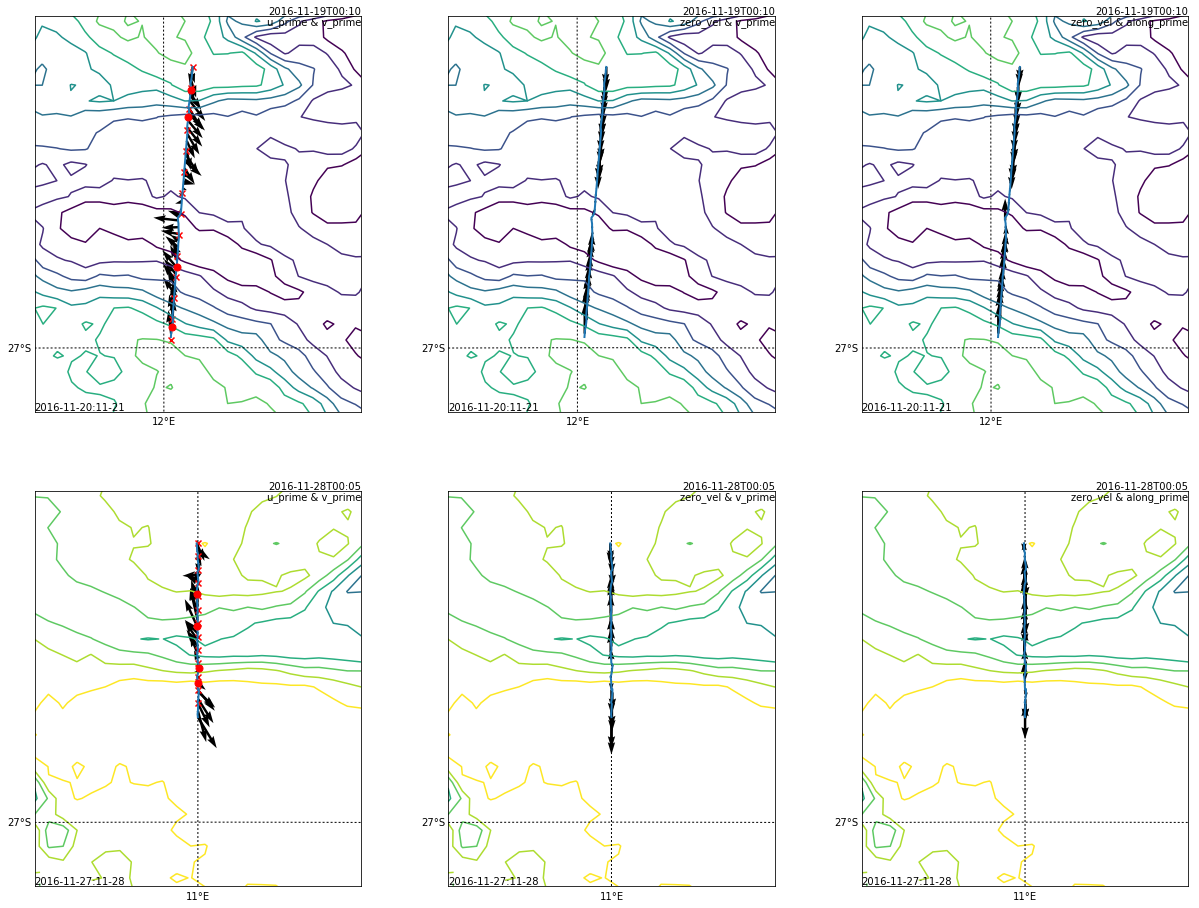

In [10]:
fig, ax = plt.subplots(ncols = 3,nrows=2, figsize=(21,16))
bwidth, bheight = 95000,115000
sst_range=np.arange(16.5,18.51,0.25) 
transect_name = 'LADCP_CTD_Transect1'
m_first = quick_map(scan_sadcp_transects_1km[transect_name],'u_prime','v_prime',sst_map_19,12.1,-26.65, bwidth, bheight,z_ind=-25,ax_in=ax[0,0],sst_range=sst_range)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.sel(x_km=7).values,scan_sadcp_transects_1km[transect_name].lat.sel(x_km=7).values,
            marker='o',color='red',markersize=7,latlon=True)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.sel(x_km=15).values,scan_sadcp_transects_1km[transect_name].lat.sel(x_km=15).values,
            marker='o',color='red',markersize=7,latlon=True)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.sel(x_km=60).values,scan_sadcp_transects_1km[transect_name].lat.sel(x_km=60).values,
            marker='o',color='red',markersize=7,latlon=True)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.sel(x_km=78).values,scan_sadcp_transects_1km[transect_name].lat.sel(x_km=78).values,
            marker='o',color='red',markersize=7,latlon=True)
# add LADCP/CTD locations
m_first.scatter(ctd_ladcp_transects_1km[transect_name].lon.values,ctd_ladcp_transects_1km[transect_name].lat.values,
            marker='x',color='red',latlon=True)
quick_map(scan_sadcp_transects_1km[transect_name],'zero_vel','v_prime',sst_map_19,12.1,-26.65, bwidth, bheight,z_ind=-25,ax_in=ax[0,1],sst_range=sst_range)
quick_map(scan_sadcp_transects_1km[transect_name],'zero_vel','along_prime',sst_map_19,12.1,-26.65, bwidth, bheight,z_ind=-25,ax_in=ax[0,2],reverse_flag=True,sst_range=sst_range)

transect_name = 'LADCP_CTD_Transect5'
m_first = quick_map(scan_sadcp_transects_1km[transect_name],'u_prime','v_prime',sst_map_28,11,-26.65, bwidth, bheight, z_ind=-25,ax_in=ax[1,0],sst_range=sst_range)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.sel(x_km=12).values,scan_sadcp_transects_1km[transect_name].lat.sel(x_km=12).values,
            marker='o',color='red',markersize=7,latlon=True)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.sel(x_km=17).values,scan_sadcp_transects_1km[transect_name].lat.sel(x_km=17).values,
            marker='o',color='red',markersize=7,latlon=True)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.sel(x_km=30).values,scan_sadcp_transects_1km[transect_name].lat.sel(x_km=30).values,
            marker='o',color='red',markersize=7,latlon=True)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.sel(x_km=40).values,scan_sadcp_transects_1km[transect_name].lat.sel(x_km=40).values,
            marker='o',color='red',markersize=7,latlon=True)
# add LADCP/CTD locations
m_first.scatter(ctd_ladcp_transects_1km[transect_name].lon.values,ctd_ladcp_transects_1km[transect_name].lat.values,
            marker='x',color='red',latlon=True)
quick_map(scan_sadcp_transects_1km[transect_name],'zero_vel','v_prime',sst_map_28,11,-26.65, bwidth, bheight,z_ind=-25,ax_in=ax[1,1],sst_range=sst_range)
quick_map(scan_sadcp_transects_1km[transect_name],'zero_vel','along_prime',sst_map_28,11,-26.65, bwidth, bheight,z_ind=-25,ax_in=ax[1,2],sst_range=sst_range)


#### Figure caption: Map of transect of interest with vectors showing both components of eddy velocity (left panel), v-component of eddy velocity (middle) and along-track component (right panel). The upper panels show the first Scanfish transect, the bottom panels the second transect. The coloured line contours show SST, with a colormap that matches the following plots. The eddy velocity simply means the velocity after removing the mean. Image dates are shown in the top right, transect dates in the bottom left.

Object `cases` not found.


/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


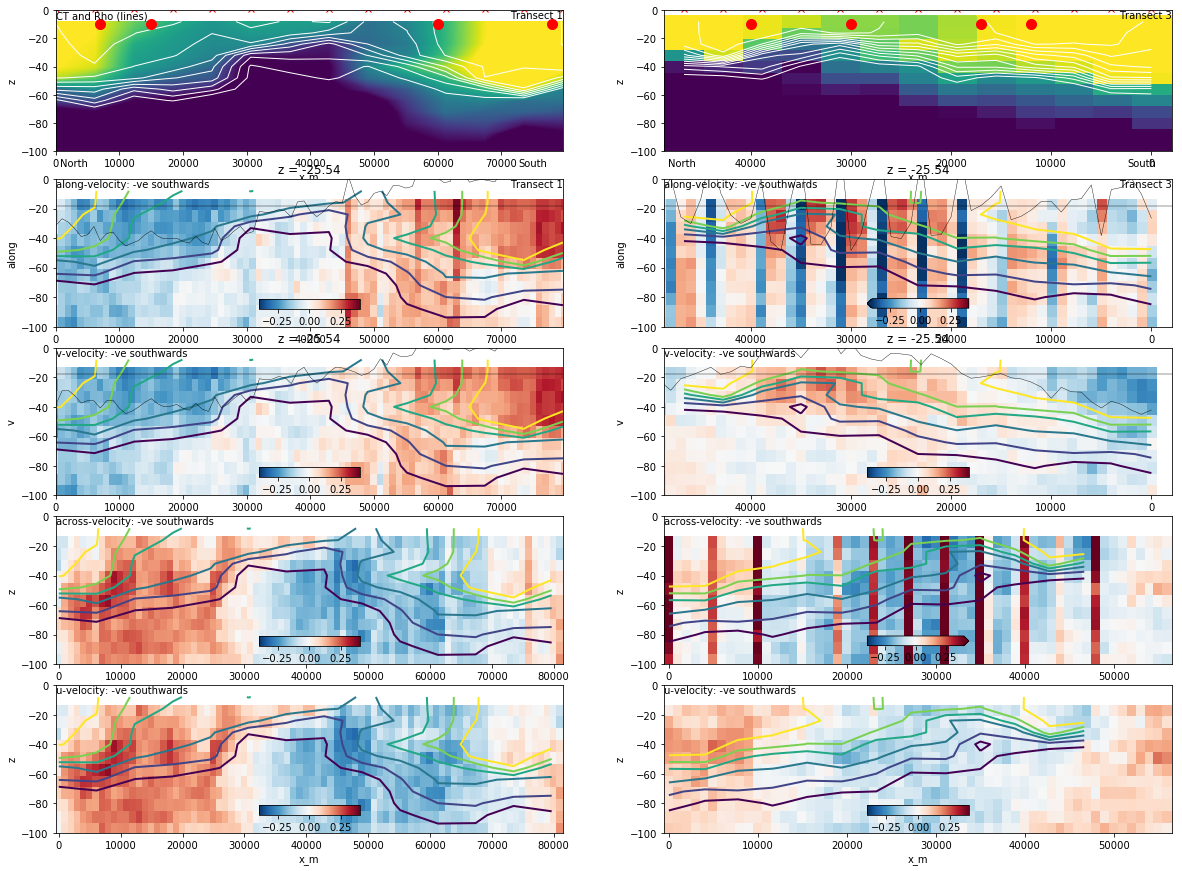

In [11]:
!! Need to identify upwelling and downwelling
!! Are -ve = southwards correct in all cases?

# VELOCITIES (minus mean) ACROSS THE FRONT

sigma_range = np.array((25,26.)) #Rho_range-1000
sigma_levels = np.arange(sigma_range[0]+.1,sigma_range[1]+.1,0.05)
CT_range = np.array((15.,17.51)) #Rho_range-1000
CT_levels = np.arange(CT_range[0],CT_range[1],0.5)
CT_levels2 = np.arange(CT_range[0],CT_range[1],0.01)
vel_range = np.array((-0.4,0.4))

transect_name1 = 'LADCP_CTD_Transect1'
transect_name2 = 'LADCP_CTD_Transect5'

ncols, nrows = 2, 5
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(20,15))
ax = ax.ravel()

si = 0
ctd_ladcp_transects_1km[transect_name1].CT.reset_index('xy').plot.contourf(x='x_m',y='z',ax=ax[si],add_colorbar=False,cmap=plt.cm.viridis,levels=CT_levels2,ylim=(-100,0))
ctd_ladcp_transects_1km[transect_name1].sigma_0.reset_index('xy').plot.contour(x='x_m',y='z',levels = sigma_levels,colors='white',linewidths=1,ax=ax[si])
ax[si].text(0,1,'CT and Rho (lines)',transform=ax[si].transAxes,horizontalalignment='left',verticalalignment='top')
ax[si].text(1,1,'Transect 1',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='top')
ax[si].text(5/80,-0.12,'North',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='bottom')
ax[si].text(7.75/8,-0.12,'South',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='bottom')
ax[si].plot(scan_sadcp_transects_1km[transect_name1].x_m.sel(x_km=7).values,-10,marker='o',color='red',markersize=10)
ax[si].plot(scan_sadcp_transects_1km[transect_name1].x_m.sel(x_km=15).values,-10,marker='o',color='red',markersize=10)
ax[si].plot(scan_sadcp_transects_1km[transect_name1].x_m.sel(x_km=60).values,-10,marker='o',color='red',markersize=10)
ax[si].plot(scan_sadcp_transects_1km[transect_name1].x_m.sel(x_km=78).values,-10,marker='o',color='red',markersize=10)
# add LADCP/CTD locations
ax[si].plot(ctd_ladcp_transects_1km[transect_name1].x_m.values,1+0*ctd_ladcp_transects_1km[transect_name1].x_m.values,
            marker='x',color='red')

x_lim1 = ax[si].get_xlim()

si = 1
ctd_ladcp_transects_1km[transect_name2].CT.reset_index('xy').plot.pcolormesh(x='x_m',y='z',ax=ax[si],add_colorbar=False,cmap=plt.cm.viridis,levels=CT_levels2,ylim=(-100,0))
ctd_ladcp_transects_1km[transect_name2].sigma_0.reset_index('xy').plot.contour(x='x_m',y='z',levels = sigma_levels,colors='white',linewidths=1,ax=ax[si])
ax[si].text(1,1,'Transect 3',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='top')
# flipping x axis to match Transect 1 - North to South
x_lim2 = ax[si].get_xlim()
ax[si].set_xlim(x_lim2[1],x_lim2[0])
x_lim2 = ax[si].get_xlim()
ax[si].text(5/80,-0.12,'North',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='bottom')
ax[si].text(7.75/8,-0.12,'South',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='bottom')
ax[si].plot(scan_sadcp_transects_1km[transect_name2].x_m.sel(x_km=12).values,-10,marker='o',color='red',markersize=10)
ax[si].plot(scan_sadcp_transects_1km[transect_name2].x_m.sel(x_km=17).values,-10,marker='o',color='red',markersize=10)
ax[si].plot(scan_sadcp_transects_1km[transect_name2].x_m.sel(x_km=30).values,-10,marker='o',color='red',markersize=10)
ax[si].plot(scan_sadcp_transects_1km[transect_name2].x_m.sel(x_km=40).values,-10,marker='o',color='red',markersize=10)
# add LADCP/CTD locations
ax[si].plot(ctd_ladcp_transects_1km[transect_name2].x_m.values,1+0*ctd_ladcp_transects_1km[transect_name2].x_m.values,
            marker='x',color='red')

si = 2
plt_vel_and_CT(track_name=transect_name1,var_name='along',si=si,reverse_flag=True,ctd_ladcp_transects_1km=ctd_ladcp_transects_1km) # reversed to -ve southwards
ax[si].text(1,1,'Transect 1',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='top')
z_top = 18 # showing velocities at z_ind as line, to check -ve vs +ve
((-100*scan_sadcp_transects_1km[transect_name1]['along']-(-100*scan_sadcp_transects_1km[transect_name1]['along'].mean(dim='xy')))-z_top).reset_index('xy').sel(z=-25,method='nearest').plot(
    x='x_m',ax=ax[si],xlim=x_lim1,linewidth=0.4,color='black')
ax[si].axhline(y=-z_top,linewidth=0.4,color='black')

plt_vel_and_CT(track_name=transect_name1,var_name='v',si=si+2,ctd_ladcp_transects_1km=ctd_ladcp_transects_1km)
z_top = 18 # showing velocities at z_ind as line, to check -ve vs +ve
((100*scan_sadcp_transects_1km[transect_name1]['v']-(100*scan_sadcp_transects_1km[transect_name1]['v'].mean(dim='xy')))-z_top).reset_index('xy').sel(z=-25,method='nearest').plot(
    x='x_m',ax=ax[si+2],xlim=x_lim1,linewidth=0.4,color='black')
ax[si+2].axhline(y=-z_top,linewidth=0.4,color='black')

si = 3
plt_vel_and_CT(track_name=transect_name2,var_name='along',si=si,ctd_ladcp_transects_1km=ctd_ladcp_transects_1km)
((-100*scan_sadcp_transects_1km[transect_name2]['along']-(-100*scan_sadcp_transects_1km[transect_name2]['along'].mean(dim='xy')))-z_top).reset_index('xy').sel(z=-25,method='nearest').plot(
    x='x_m',ax=ax[si],xlim=x_lim2,linewidth=0.4,color='black')
ax[si].axhline(y=-z_top,linewidth=0.4,color='black')
ax[si].text(1,1,'Transect 3',transform=ax[si].transAxes,horizontalalignment='right',verticalalignment='top')

plt_vel_and_CT(track_name=transect_name2,var_name='v',si=si+2,ctd_ladcp_transects_1km=ctd_ladcp_transects_1km)
((100*scan_sadcp_transects_1km[transect_name2]['v']-(100*scan_sadcp_transects_1km[transect_name2]['v'].mean(dim='xy')))-z_top).reset_index('xy').sel(z=-25,method='nearest').plot(
    x='x_m',ax=ax[si+2],xlim=x_lim2,linewidth=0.4,color='black')
ax[si+2].axhline(y=-z_top,linewidth=0.4,color='black')

si = 6
plt_vel_and_CT(track_name=transect_name1,var_name='across',si=si,reverse_flag=True,ctd_ladcp_transects_1km=ctd_ladcp_transects_1km) # reversed to -ve southwards
plt_vel_and_CT(track_name=transect_name1,var_name='u',si=si+2,ctd_ladcp_transects_1km=ctd_ladcp_transects_1km)

si = 7
plt_vel_and_CT(track_name=transect_name2,var_name='across',si=si,ctd_ladcp_transects_1km=ctd_ladcp_transects_1km)
plt_vel_and_CT(track_name=transect_name2,var_name='u',si=si+2,ctd_ladcp_transects_1km=ctd_ladcp_transects_1km)



#### Figure caption: Cross-sections along the transects shown in the figure above, LADCP/CTD transect 1 (left panels) and 5 (right panels). The top row shows temperature (colour) and density (lines). The remaining plots show temperature as coloured contour lines and (top to bottom): along-ship velocity component, v-component, across-track component, u-component. The red dots were used to link locations in the map plot, with locations in the cross-sections. Transect 5 seems to have problem with the ship's direction, which is used to get along-, across-track velocities from u,v (which seem fine).